# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
# load data and parse date column into datetime object

calendar_train = pd.read_csv('data/calendar_train.csv', parse_dates = ['date'])
calendar_test = pd.read_csv('data/calendar_test.csv', parse_dates = ['date'])

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [6]:
# extract year, month, day from the datetime objects in the 'date' column
calendar_train['year'] = calendar_train['date'].map(lambda x: x.year)
calendar_train['month'] = calendar_train['date'].map(lambda x: x.month_name())
calendar_train['day of the month'] = calendar_train['date'].map(lambda x: x.day)
calendar_train['day of the week'] = calendar_train['date'].map(lambda x: x.day_name())
calendar_train['day of the week integer'] = calendar_train['date'].map(lambda x: x.weekday())

In [7]:
# repeat extracting day of the week for the testing set too in preparation for later question

# extract year, month, day from the datetime objects in the 'date' column
calendar_test['year'] = calendar_test['date'].map(lambda x: x.year)
calendar_test['month'] = calendar_test['date'].map(lambda x: x.month_name())
calendar_test['day of the month'] = calendar_test['date'].map(lambda x: x.day)
calendar_test['day of the week'] = calendar_test['date'].map(lambda x: x.day_name())
calendar_test['day of the week integer'] = calendar_test['date'].map(lambda x: x.weekday())

In [8]:
# calculate average price by month
print('Mean price by month:\n\n', calendar_train.groupby(['month']).mean()['price'], '\n\n')

# calculate average price by day of the week
print('Mean price by day of the week:\n\n', calendar_train.groupby(['day of the week']).mean()['price'])


Mean price by month:

 month
April        278.442433
August       272.628181
December     190.547291
February     190.617247
January      185.940598
July         281.397202
June         276.534729
March        220.600371
May          288.174429
November     222.407229
October      271.807400
September    263.820183
Name: price, dtype: float64 


Mean price by day of the week:

 day of the week
Friday       247.686228
Monday       235.088040
Saturday     249.484869
Sunday       237.755570
Thursday     237.950429
Tuesday      233.591537
Wednesday    230.638254
Name: price, dtype: float64


Text(0.5, 0, 'Day of the week')

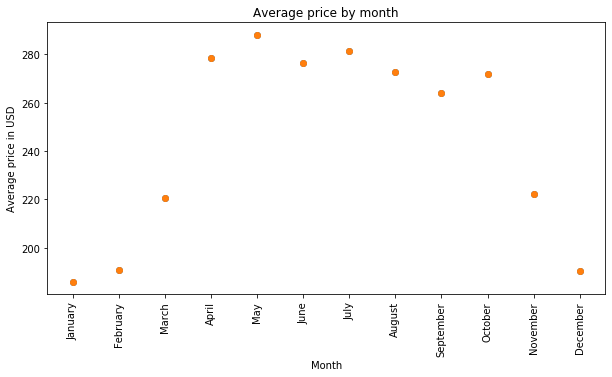

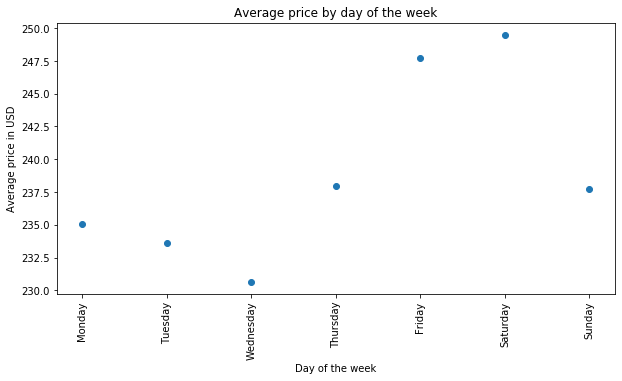

In [57]:
# plot average price by month

plt.rcParams["figure.figsize"] = [10,5]
fig, ax1 = plt.subplots(1,1)
# sort data on x axis
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.plot(pd.DataFrame(calendar_train.groupby(['month']).mean()).loc[month_order]['price'], marker = 'o', linewidth = 0)
plt.plot(calendar_train.groupby(['month']).mean()['price'], marker = 'o', linewidth = 0)
plt.xticks(rotation='vertical')
ax1.set_title("Average price by month")
ax1.set_ylabel("Average price in USD")
ax1.set_xlabel("Month")

# plot average price by day of the week

fig2, ax2 = plt.subplots(1,1)
# sort data on x axis
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.plot(pd.DataFrame(calendar_train.groupby(['day of the week']).mean()).loc[day_order]['price'], marker = 'o', linewidth = 0)
plt.xticks(rotation='vertical')
ax2.set_title("Average price by day of the week")
ax2.set_ylabel("Average price in USD")
ax2.set_xlabel("Day of the week")



We notice that the average price by month is generally low in winter months (December, January, and February), rises through the spring (March, April, and May), and remains high during the summer (June, July, and August) although some decline in price is observed from May to June and July to August. In the fall (September, October, and November), the average price transitions from moderately high (approx 265 USD) to lower (approx 220 USD). The overall trend is that as the weather gets warmer, the average price increases and as the weather gets cooler, the average price decreases. This makes sense because during the summer when people more frequently are on vacation, AirBnB rentals would be desirable and therefore prices would rise. Furthermore, there are some famous social events in Boston in April--the Boston Marathon is traditionally held in April. Thus, it follows that more there are more visitors and or competitors who travel to Boston and require overnight housing. This sudden influx of housing demand will likely increase AirBnB's prices. This relaitonship of price and demand follow simple econometric trends.



From the plot of average price vs. day of the week, we can see that the price is high on Friday and Saturday nights, moderate on Thursday and Sunday nights, and low for Monday through Wednesday nights. This trend indicates that the price for the weekend nights is higher than for weekdays in general. This makes sense because people have time on the weekends away from work to travel and therefore AirBnB rentals would be desirable so prices would rise. In other words, it follows that individuals may choose to travel to Boston through the weekend and require additional housing.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

### Create clean training and testing dataframes

In [58]:
# filter out NaN values where price is not available

calendar_train_available = calendar_train[calendar_train['available']=='t']
calendar_test_available = calendar_test[calendar_test['available']=='t']

In [59]:
# encode month names in training data as integers in order to retain this information once the data are grouped to take daily averages

le_calendar_train_available=LabelEncoder().fit(calendar_train_available.month)
le_calendar_train_available.transform(calendar_train_available.month)
calendar_train_available['month integer'] = le_calendar_train_available.transform(calendar_train_available.month)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [60]:
# show the names of the months in the order that the encoding was done
# so April = 0; August = 1; etc to September = 11
le_calendar_train_available.classes_

array(['April', 'August', 'December', 'February', 'January', 'July',
       'June', 'March', 'May', 'November', 'October', 'September'],
      dtype=object)

In [61]:
# encode month names in testing data as integers in order to retain this information once the data are grouped to take daily averages

le_calendar_test_available=LabelEncoder().fit(calendar_test_available.month)
le_calendar_test_available.transform(calendar_test_available.month)
calendar_test_available['month integer'] = le_calendar_test_available.transform(calendar_test_available.month)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [62]:
# find difference in days between each date and the earliest date in the column
# store the numerical date as a column in the filtered dataframe

calendar_train_available['numerical_date_dt'] = (calendar_train_available['date'] - calendar_train_available['date'].min())
calendar_test_available['numerical_date_dt'] = (calendar_test_available['date'] - calendar_test_available['date'].min())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [63]:
# remove units from the datetime object and store clean variable in the numerical date column

calendar_train_available['numerical_date'] = calendar_train_available['numerical_date_dt'].map(lambda x: x.days)
calendar_test_available['numerical_date'] = calendar_test_available['numerical_date_dt'].map(lambda x: x.days)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [77]:
# check training dataframe to make sure it shows numerical date column correctly

calendar_train_available.head()

,listing_id,date,available,price,year,month,day of the month,day of the week,day of the week integer,month integer,numerical_date_dt,numerical_date
123,20872145,2018-04-02,t,62.0,2018,April,2,Monday,0,0,178 days,178
124,20872145,2018-04-01,t,59.0,2018,April,1,Sunday,6,0,177 days,177
125,20872145,2018-03-31,t,75.0,2018,March,31,Saturday,5,7,176 days,176
126,20872145,2018-03-30,t,71.0,2018,March,30,Friday,4,7,175 days,175
127,20872145,2018-03-28,t,51.0,2018,March,28,Wednesday,2,7,173 days,173


In [65]:
# check testing dataframe to make sure it shows numerical date column correctly

calendar_test_available.head()

,listing_id,date,available,price,year,month,day of the month,day of the week,day of the week integer,month integer,numerical_date_dt,numerical_date
0,21205442,2018-09-28,t,138.0,2018,September,28,Friday,4,11,357 days,357
1,5166870,2018-08-11,t,210.0,2018,August,11,Saturday,5,1,309 days,309
12,19455818,2018-04-13,t,869.0,2018,April,13,Friday,4,0,189 days,189
14,20351854,2017-12-23,t,239.0,2017,December,23,Saturday,5,2,78 days,78
17,20622324,2018-02-09,t,259.0,2018,February,9,Friday,4,3,126 days,126


In [66]:
# check that there are no negative numerical_date values, since this column is number of days elapsed since earliest date

calendar_train_available['numerical_date'].describe()

count    309288.000000
mean        174.542853
std         100.967719
min           0.000000
25%          88.000000
50%         163.000000
75%         261.000000
max         364.000000
Name: numerical_date, dtype: float64

In [67]:
# check that there are no negative numerical_date values, since this column is number of days elapsed since earliest date

calendar_test_available['numerical_date'].describe()

count    133100.000000
mean        174.506086
std         100.771816
min           0.000000
25%          87.000000
50%         163.000000
75%         261.000000
max         364.000000
Name: numerical_date, dtype: float64

In [68]:
# take mean of each variable for each day and store daily averages as new dataframe
# this step of the data cleaning process is useful for fitting the polynomial models and is approved on Ed

calendar_train_available_daygroups = calendar_train_available.groupby(['numerical_date']).mean()
calendar_test_available_daygroups = calendar_test_available.groupby(['numerical_date']).mean()

In [69]:
# store numerical date as a column in the dataframe instead of just as the index

calendar_train_available_daygroups['numerical_date'] = calendar_train_available_daygroups.index
calendar_test_available_daygroups['numerical_date'] = calendar_test_available_daygroups.index

In [70]:
# check training dataframe to make sure it shows numerical date column correctly

calendar_train_available_daygroups.head()

,listing_id,price,year,day of the month,day of the week integer,month integer,numerical_date
numerical_date,,,,,,,
0,1.322575e+07,370.173410,2017.0,6.0,4.0,10.0,0
1,1.258238e+07,409.298701,2017.0,7.0,5.0,10.0,1
2,1.217451e+07,299.128713,2017.0,8.0,6.0,10.0,2
3,1.232258e+07,282.768908,2017.0,9.0,0.0,10.0,3
4,1.227489e+07,275.933202,2017.0,10.0,1.0,10.0,4


In [71]:
# check testing dataframe to make sure it shows numerical date column correctly

calendar_test_available_daygroups.head()

,listing_id,price,year,day of the month,day of the week integer,month integer,numerical_date
numerical_date,,,,,,,
0,1.184651e+07,340.312500,2017.0,6.0,4.0,10.0,0
1,1.181977e+07,375.779412,2017.0,7.0,5.0,10.0,1
2,1.185502e+07,297.661654,2017.0,8.0,6.0,10.0,2
3,1.307946e+07,281.650000,2017.0,9.0,0.0,10.0,3
4,1.257350e+07,263.392344,2017.0,10.0,1.0,10.0,4


In [72]:
# check that there are no negative numerical_date values, since this column is number of days elapsed since earliest date

calendar_train_available_daygroups['numerical_date'].describe()

count    365.000000
mean     182.000000
std      105.510663
min        0.000000
25%       91.000000
50%      182.000000
75%      273.000000
max      364.000000
Name: numerical_date, dtype: float64

In [73]:
# check that there are no negative numerical_date values, since this column is number of days elapsed since earliest date

calendar_test_available_daygroups['numerical_date'].describe()

count    365.000000
mean     182.000000
std      105.510663
min        0.000000
25%       91.000000
50%      182.000000
75%      273.000000
max      364.000000
Name: numerical_date, dtype: float64

### 1. Polynomials

When fitting the models, we will do two approaches: 1) training the model on all of the data, 2) training the data on only the daily averages. We report $R^2$ values for each fit model for all of the data and for the daily averages in training and testing.


In [26]:
# TF approved using this import for clearly presenting information

import sys
!{sys.executable} -m pip install PrettyTable
from prettytable import PrettyTable

In [74]:
# isolate relevant predictor
xpred = pd.DataFrame({"numerical_date":np.arange(1,366,1)})

+-------------------------------+----------------------+
| Dataset for Model of Degree 2 |       R2 Score       |
+-------------------------------+----------------------+
|  Daily Averages Training Data | 0.15045780647345564  |
|    Daily Averages Test Data   | 0.16101677112102541  |
|       All Training Data       | 0.018488573687428622 |
|         All Test Data         | 0.019180392770215438 |
+-------------------------------+----------------------+
+-------------------------------+---------------------+
| Dataset for Model of Degree 3 |       R2 Score      |
+-------------------------------+---------------------+
|  Daily Averages Training Data |  0.6277531018050957 |
|    Daily Averages Test Data   |   0.60577185275048  |
|       All Training Data       | 0.03893294505042644 |
|         All Test Data         | 0.03875184567550083 |
+-------------------------------+---------------------+
+-------------------------------+----------------------+
| Dataset for Model of Degree 5 |      

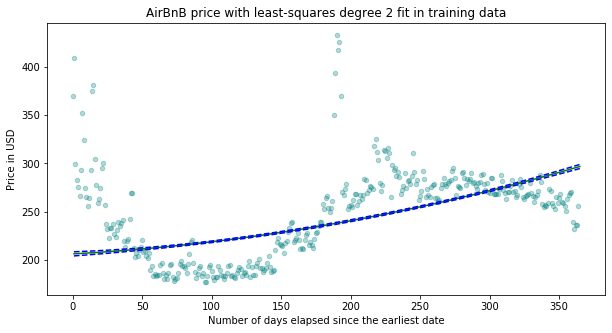

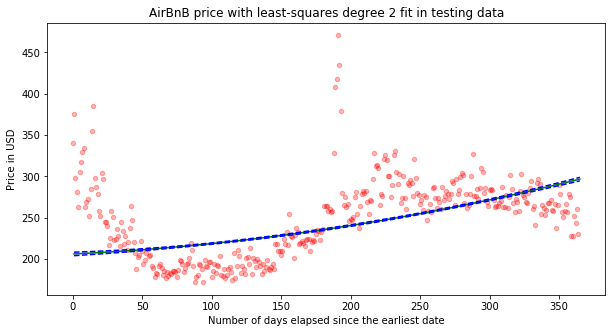

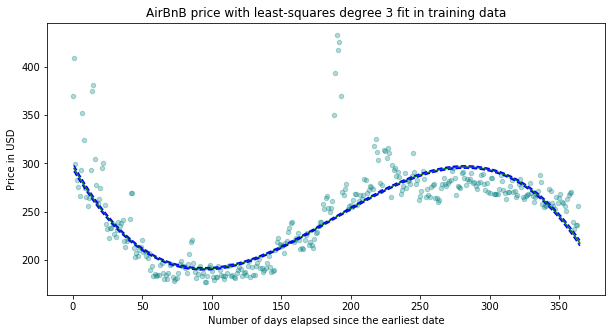

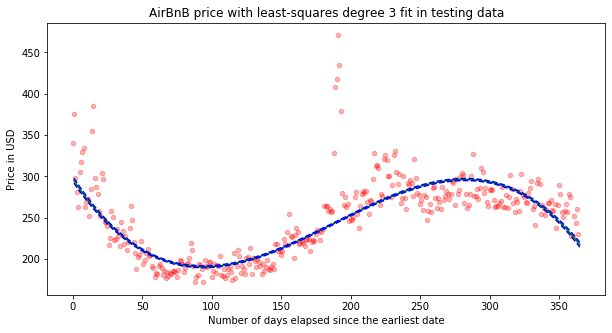

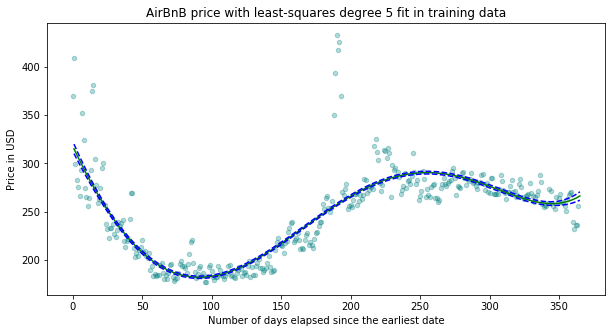

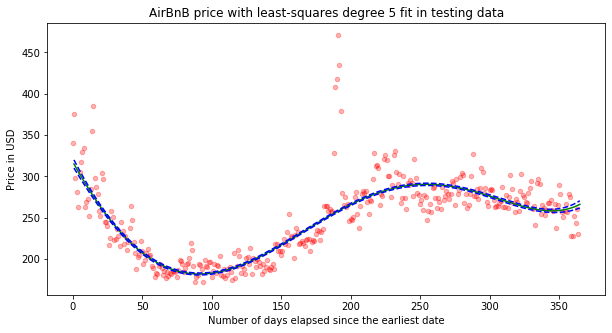

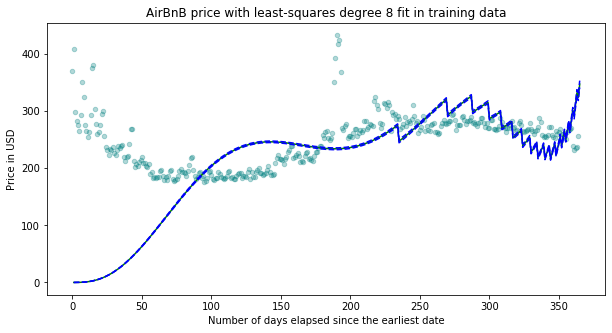

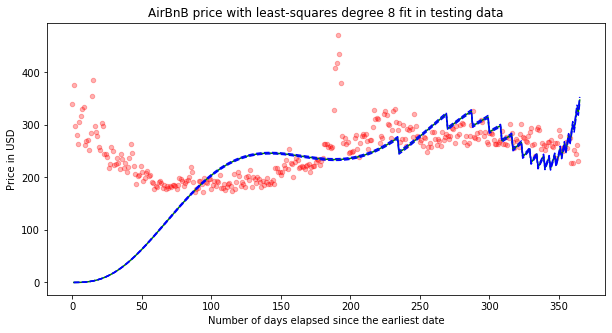

In [28]:
# make polynomial models trained using all data (not daily averages)
# models are fit to both all the training (then testing) data as well as the daily average training (and testing) data

degree=[2,3,5,8]
for degree in degree:
    model = sm.ols(formula = 'price ~ np.vander(numerical_date,degree+1, increasing=True)-1', data = calendar_train_available).fit()
    poly_predictions_test = model.get_prediction(calendar_test_available).summary_frame()
    poly_predictions_train = model.get_prediction(calendar_train_available).summary_frame()
    poly_predictions_plot_train = model.get_prediction(xpred).summary_frame()
    poly_predictions_plot_test = model.get_prediction(xpred).summary_frame()
    #plotting the training data
    plot_poly= calendar_train_available_daygroups.plot.scatter(x='numerical_date',y='price',c='Teal',title='AirBnB price with least-squares degree {} fit in training data'.format(degree),alpha=0.3)
    plot_poly.set_xlabel("Number of days elapsed since the earliest date")
    plot_poly.set_ylabel("Price in USD")
    #plotting the mean from the model's predictions & 95% confidence interval
    
    plot_poly.plot(xpred, poly_predictions_plot_train['mean'],color="green")
    plot_poly.plot(xpred, poly_predictions_plot_train['mean_ci_lower'], color="blue",linestyle="dashed")
    plot_poly.plot(xpred, poly_predictions_plot_train['mean_ci_upper'], color="blue",linestyle="dashed");
    #plot testing data
    
    plot_poly = calendar_test_available_daygroups.plot.scatter(x='numerical_date',y='price',c='Red',title="AirBnB price with least-squares degree {} fit in testing data".format(degree),alpha=0.3)
    plot_poly.set_xlabel("Number of days elapsed since the earliest date")
    plot_poly.set_ylabel("Price in USD")
    # plot the mean from the model's predictions along with 95% confidence bounds
    
    plot_poly.plot(xpred, poly_predictions_plot_test['mean'],color="green")
    plot_poly.plot(xpred, poly_predictions_plot_test['mean_ci_lower'], color="blue",linestyle="dashed")
    plot_poly.plot(xpred, poly_predictions_plot_test['mean_ci_upper'], color="blue",linestyle="dashed");
    t = PrettyTable(['Dataset for Model of Degree {}'.format(degree),'R2 Score'])
    t.add_row(['Daily Averages Training Data',r2_score(calendar_train_available_daygroups['price'], poly_predictions_plot_train['mean'])])
    t.add_row(['Daily Averages Test Data',r2_score(calendar_test_available_daygroups['price'], poly_predictions_plot_test['mean'])])
    t.add_row(['All Training Data',r2_score(calendar_train_available['price'], poly_predictions_train['mean'])])
    t.add_row(['All Test Data',r2_score(calendar_test_available['price'], poly_predictions_test['mean'])])
    print(t)

It is important to note the difference between the two aforementioned methods: $1$) fitting the model on the daily averaged price and $2$)fitting the model on all of the data. In truth, option $1$ was implemented due to discrepancies in Ed. Method $2$) makes more sense because we are fitting our model on all of the possible information. While method $1$ seemingly performs better, shown by the markedly higher $R^2$ scores (consider model of degree $2$ training data $0.15$ vs. $0.018$), this method effectively smooths the data by fitting the model on the mean of price per date.

Therefore, discussion of $R^2$ scores will be about the models fitted on all of the data.

As shown in the above tables in rows concerning "All Training Data" and "All Test Data", we see that the $R^2$ score is highest at degree $5$; consider the "All Test Data" $R^2$ score for model of degree $5$ ($0.0417$) vs that of model of degree $3$ ($0.0388$) vs. model of degree $2$ ($0.0192$) vs. model of degree $8$ ($-0.16$). Clearly, we see that up to certain point, increasing the degree of our polynomial model improves $R^2$ score. We will later discuss the oddity we see with the model of degree $8$.

Interestingly, we also observe that $R^2$ scores are slightly lower than in the training set, which is expected since the models were fit using the training set and evaluated on the test set (non-overlapping data with the training set). The $R^2$ values in the test set are largest for the degree 5 polynomial and smallest for the degree 8 polynomial (they increase from degree 2 to degree 3 to degree 5), and the same trends of relative model strength are observed in the training set.  

### 2. Degree 8 oddity

The degree 8 polynomial's predictions are very poor as evidenced by the $R^2$ values of $-0.17$ and $-0.16$ in the training and testing sets, respectively. These negative values with magnitude greater than 1 indicate that the model's predictions are worse than having no model at all.

The most unusal predictions from the model are at the edges of the domain (x data), which is consistent with Runge's phenomenon of having oscillation of the model at limits of the domain where there is also not as much data. 

Runge's phenomenon occurs for several key reasons: $1$)the magnitude of the $n$-th order derivatives grows quickly as $n$ increases, $2$)Polynomials are often oscillatory in nature. As the degree of the polynomial increases, the number of oscillations does too, and $3$) Let $X$ be the matrix of observed data. We find that as the order of a polynomial regression increases, the $X'X$ matrix becomes ill-conditioned. It is possible that this ill-conditioning introduces multicollinearity in the columns of the $X$ matrix.

Potential Solutions:
Use spline curves which are piecewise polynomials by definition. 
This phenomenon is one reason why we would want to use a natural spline which enforces that the model is linear at the edges. We know that the degree 8 oddity is not just a case of overfitting because the model has nonsense predictions especially at the edges of the data; it does not simply have very high variance.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In [33]:
# choose smoothness parameters to check

#candidate_smoothings = np.linspace(0,1000,10)
#candidate_smoothings = [1000,1,0.03,1e-2,1e-3,1e-4,1e-5,0]
# candidate_smoothings = [1000,1,0.03,1e-2,1e-3,1e-4,1e-5,0]
#candidate_smoothings = np.logspace(-2,1,40)

# use this set of candidate smoothings after inspecting a larger range and noticing this is the most important range
candidate_smoothings = np.linspace(0.27,0.3,50)
kf = KFold(n_splits=50, random_state=47, shuffle=True)
scores = np.zeros((50,len(candidate_smoothings)))
# for each train/test split, fit a model and evaluate the r2
for i, (train_index, test_index) in enumerate(kf.split(calendar_train_available_daygroups)):
    train_df = calendar_train_available_daygroups.iloc[train_index,:]
    test_df = calendar_train_available_daygroups.iloc[test_index,:]
    for j,cur_smoothing in enumerate(candidate_smoothings):
        cur_model = LinearGAM(lam=cur_smoothing, n_splines=50).fit(train_df['numerical_date'],train_df['price'])
        
        scores[i,j] = r2_score(test_df['price'], cur_model.predict(test_df['numerical_date']))
        
#np.mean(scores, axis=0)

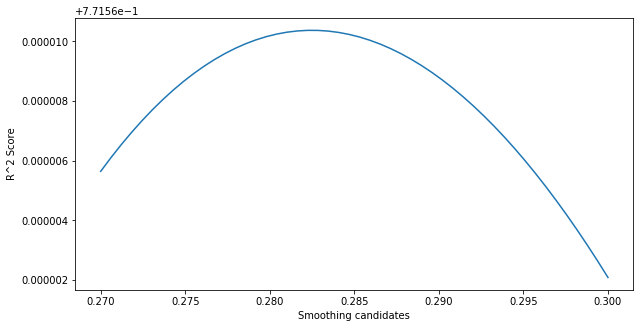

candidate_smoothings:

 [0.27       0.27061224 0.27122449 0.27183673 0.27244898 0.27306122
 0.27367347 0.27428571 0.27489796 0.2755102  0.27612245 0.27673469
 0.27734694 0.27795918 0.27857143 0.27918367 0.27979592 0.28040816
 0.28102041 0.28163265 0.2822449  0.28285714 0.28346939 0.28408163
 0.28469388 0.28530612 0.28591837 0.28653061 0.28714286 0.2877551
 0.28836735 0.28897959 0.28959184 0.29020408 0.29081633 0.29142857
 0.29204082 0.29265306 0.29326531 0.29387755 0.2944898  0.29510204
 0.29571429 0.29632653 0.29693878 0.29755102 0.29816327 0.29877551
 0.29938776 0.3       ] 


best smoothing:

 0.28224489795918367


In [34]:
# show how r2 score changes as smoothing increases

plt.plot(candidate_smoothings, np.mean(scores,axis=0))
plt.xlabel("Smoothing candidates")
plt.ylabel("R^2 Score")

plt.show()
print('candidate_smoothings:\n\n', candidate_smoothings, '\n\n')
print('best smoothing:\n\n', candidate_smoothings[np.argmax(np.mean(scores,axis=0))])

train r2: 0.8434015216715972
test r2: 0.811468515389187


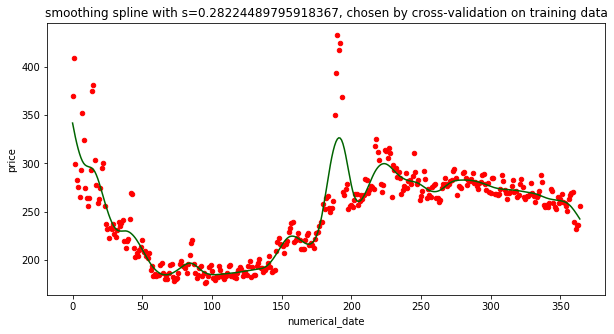

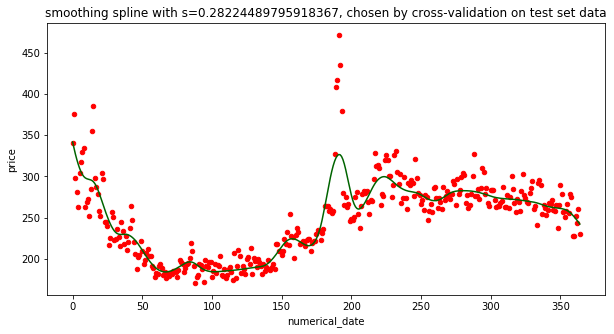

In [35]:
# plot data and model using best smoothing

best_s = candidate_smoothings[np.argmax(np.mean(scores, axis=0))]

ax3 = calendar_train_available_daygroups.plot.scatter(x='numerical_date',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation on training data".format(best_s))
best_model = LinearGAM(lam=best_s, n_splines=50).fit(calendar_train_available_daygroups['numerical_date'],calendar_train_available_daygroups['price'])
ax3.plot(calendar_train_available_daygroups['numerical_date'], best_model.predict(calendar_train_available_daygroups['numerical_date']), color="darkgreen")

ax4 = calendar_test_available_daygroups.plot.scatter(x='numerical_date',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation on test set data".format(best_s))

ax4.plot(calendar_test_available_daygroups['numerical_date'], best_model.predict(calendar_test_available_daygroups['numerical_date']), color="darkgreen")

print('train r2:', r2_score(calendar_train_available_daygroups['price'], best_model.predict(calendar_train_available_daygroups['numerical_date'])))
print('test r2:', r2_score(calendar_test_available_daygroups['price'], best_model.predict(calendar_test_available_daygroups['numerical_date'])))

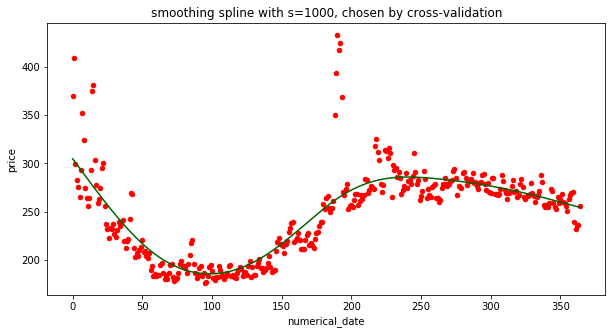

train r2: 0.724147027207327
test r2: 0.6934933342493055


In [36]:
# show effect of having more smoothing 
best_s = 1000

ax = calendar_train_available_daygroups.plot.scatter(x='numerical_date',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation".format(best_s))
best_model = LinearGAM(lam=best_s, n_splines=50).fit(calendar_train_available_daygroups['numerical_date'],calendar_train_available_daygroups['price'])
ax.plot(calendar_train_available_daygroups['numerical_date'], best_model.predict(calendar_train_available_daygroups['numerical_date']), color="darkgreen")
plt.show()
print('train r2:', r2_score(calendar_train_available_daygroups['price'], best_model.predict(calendar_train_available_daygroups['numerical_date'])))
print('test r2:', r2_score(calendar_test_available_daygroups['price'], best_model.predict(calendar_test_available_daygroups['numerical_date'])))

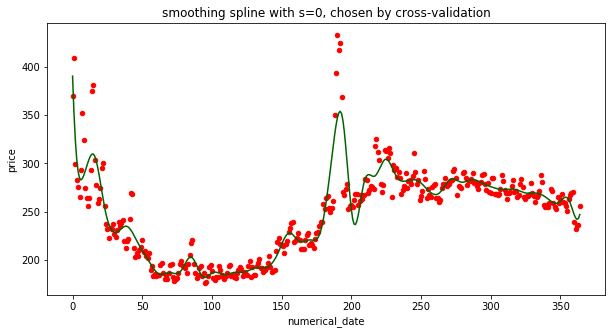

train r2: 0.8677205645446704
test r2: 0.8306158483166475


In [37]:
# show effect of having less smoothing 
best_s = 0

ax = calendar_train_available_daygroups.plot.scatter(x='numerical_date',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation".format(best_s))
best_model = LinearGAM(lam=best_s, n_splines=50).fit(calendar_train_available_daygroups['numerical_date'],calendar_train_available_daygroups['price'])
ax.plot(calendar_train_available_daygroups['numerical_date'], best_model.predict(calendar_train_available_daygroups['numerical_date']), color="darkgreen")
plt.show()
print('train r2:', r2_score(calendar_train_available_daygroups['price'], best_model.predict(calendar_train_available_daygroups['numerical_date'])))
print('test r2:', r2_score(calendar_test_available_daygroups['price'], best_model.predict(calendar_test_available_daygroups['numerical_date'])))

### 4. Effects of parameters

Of the models, the smoothing spline model with smoothing of 0.28 performs the best because its testing $R^2$ of 0.81 is the highest of all models evaluated. As the degree increase in the polynomial model from 2 to 3 to 5, the $R^2$ values in the test set increase from degree 2 to degree 3 to degree 5 and then decrease at degree 8 (the same trends of relative model strength are observed in the training set). As smoothness penalty increases, the model becomes less smooth (more bias and less variance) as evidenced by the plot above with s=1000 but when smoothness penalty decreases to 0 the model becomes more jagged and there is more variance with less bias. The training $R^2$ is 0.72 while it is 0.69 for testing when smoothness penalty is 1000 (more smooth model) and the training $R^2$ is 0.87 while it is 0.83 for testing when smoothness penalty is 0 (more jagged model).

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [38]:
# add indicator variable to training set
calendar_train_available_daygroups['weekendyn'] = 1*((calendar_train_available_daygroups['day of the week integer']==4) | (calendar_train_available_daygroups['day of the week integer']==5))
# want equal to 4 or 5 for fri or sat

# add indicator variable to testing set
calendar_test_available_daygroups['weekendyn'] = 1*((calendar_test_available_daygroups['day of the week integer']==4) | (calendar_test_available_daygroups['day of the week integer']==5))

In [39]:
# inspect dataframe

calendar_train_available_daygroups.head()

,listing_id,price,year,day of the month,day of the week integer,month integer,numerical_date,weekendyn
numerical_date,,,,,,,,
0,1.322575e+07,370.173410,2017.0,6.0,4.0,10.0,0,1
1,1.258238e+07,409.298701,2017.0,7.0,5.0,10.0,1,1
2,1.217451e+07,299.128713,2017.0,8.0,6.0,10.0,2,0
3,1.232258e+07,282.768908,2017.0,9.0,0.0,10.0,3,0
4,1.227489e+07,275.933202,2017.0,10.0,1.0,10.0,4,0


In [40]:
# show relevant predictors in training data

calendar_train_available_daygroups.iloc[:,[5,6]].head()

,month integer,numerical_date
numerical_date,,
0,10.0,0
1,10.0,1
2,10.0,2
3,10.0,3
4,10.0,4


In [41]:
# use s=0.28

best_s = candidate_smoothings[np.argmax(np.mean(scores, axis=0))]
print('best smoothing:', best_s)
best_model = LinearGAM(s(5)+f(6),lam=best_s, n_splines=50).fit(calendar_train_available_daygroups,calendar_train_available_daygroups['price'])

print('train r2:', r2_score(calendar_train_available_daygroups['price'], best_model.predict(calendar_train_available_daygroups)))
print('test r2:', r2_score(calendar_test_available_daygroups['price'], best_model.predict(calendar_test_available_daygroups)))


best smoothing: 0.28224489795918367
train r2: 0.9622021378524963
test r2: 0.8989367793208731


The model's performance increases once the indicator variable for weekends increases. The training $R^2$ is 0.96 while it is 0.90 for testing, which are both higher than the model when the indicator variable was not included (without the indicator the training $R^2$ was 0.84 and was 0.81 for testing.

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [42]:
# sort the observations

calendar_train_available_daygroups.sort_values(by=['price'],ascending=False).head(10)


,listing_id,price,year,day of the month,day of the week integer,month integer,numerical_date,weekendyn
numerical_date,,,,,,,,
190,1.133490e+07,432.680761,2018.0,14.0,5.0,0.0,190,1
192,1.132853e+07,425.289528,2018.0,16.0,0.0,0.0,192,0
191,1.097488e+07,417.170404,2018.0,15.0,6.0,0.0,191,0
1,1.258238e+07,409.298701,2017.0,7.0,5.0,10.0,1,1
189,1.133951e+07,393.609047,2018.0,13.0,4.0,0.0,189,1
15,1.271969e+07,381.526515,2017.0,21.0,5.0,10.0,15,1
14,1.226345e+07,374.955932,2017.0,20.0,4.0,10.0,14,1
0,1.322575e+07,370.173410,2017.0,6.0,4.0,10.0,0,1
193,1.122437e+07,369.371060,2018.0,17.0,1.0,0.0,193,0


In [43]:
# This shows the mapping of the month integer column to the month names.

#['April', 'August', 'December', 'February', 'January', 'July',
#       'June', 'March', 'May', 'November', 'October', 'September']

The top 10 dates in descending order according to price are: April 14, 2018 (price 432.68 USD); April 16, 2018 (price 425.29 USD); April 15, 2018 (price 417.17); October 7, 2017 (price 409.30 USD); April 13, 2018 (price 393.61 USD); October 21, 2017 (price 381.53 USD); October 20, 2017 (price 374.96 USD); October 6, 2017 (price 370.17 USD); April 17, 2018 (price 369.37 USD); and October 13, 2017 (price 351.80 USD). The most expensive night was April 14, 2018 (price 432.68 USD) which does not appear to correspond to a notable event but might be related to the Boston Marathon occuring two days later (since the prices between the top two days are so close, this most expensive night is likely not an artifact of data collection or noise). The second most expensive night was April 16, 2018 (price 425.29 USD) which corresponds to the Boston Marathon so it is reasonable that there would be a high demand for AirBnB rentals due to racers and spectators traveling in from out of town. There are several other days near April 16, 2018 in the top 10 list shown above and all of these nights are likely related to the marathon. The third most expensive night was October 7, 2017 (price 409.30 USD) which had a Red Sox vs. Astros game as well as a Bruno Mars concert. October 6,  2017 is also one of the highest priced nights which is reasonable given the events on October 7. The The 6th and 7th most highly priced nights are October 21 and 20, respectively, and these nights could be related to the Head of the Charles which would draw many out of town travelers and drive up the costs of AirBnB rentals. 

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [44]:
# load data

listings_train = pd.read_csv('data/listings_train.csv')
listings_test = pd.read_csv('data/listings_test.csv')
listings_test.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,3,Private room,42.280279,-71.135870,2.5,1,1,271,2,2,286,17
1,1,Private room,42.285603,-71.144647,1.0,1,1,290,1,1,0,3
2,1,Private room,42.274408,-71.125294,1.0,1,3,62,1,82,240,3
3,1,Entire home/apt,42.287974,-71.129771,2.0,2,2,55,27,74,115,5
4,1,Private room,42.276913,-71.128233,1.5,1,1,326,1,1,361,27


In [45]:
# additional predictors

predictors = listings_train.columns.to_list()
len(predictors)

12

In [46]:
listings_train.head()
listings_train['room_type']=LabelEncoder().fit_transform(listings_train['room_type'])
listings_test['room_type']=LabelEncoder().fit_transform(listings_test['room_type'])

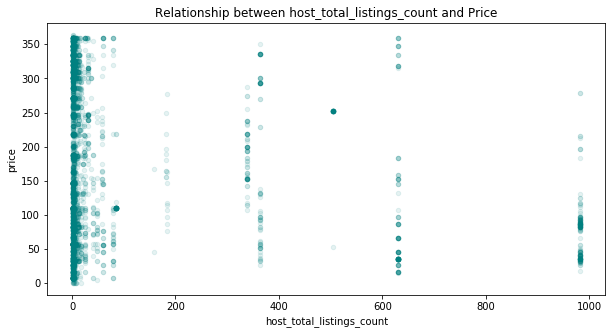

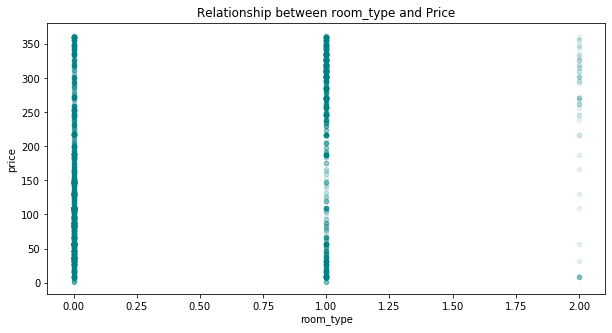

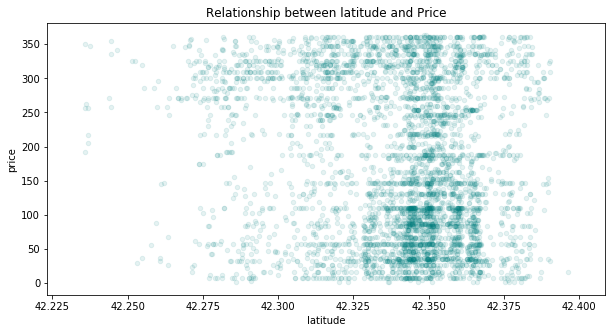

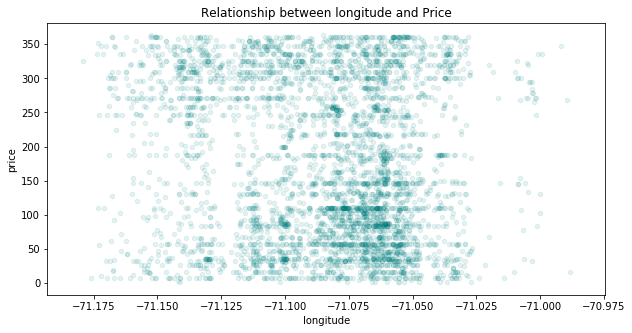

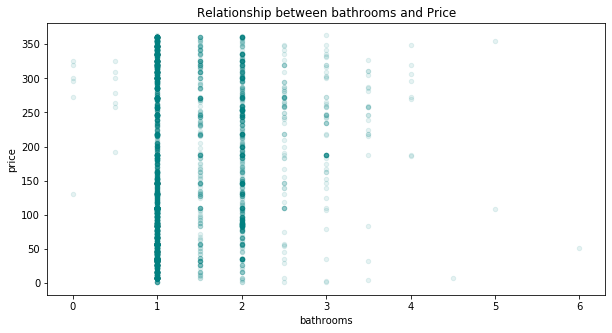

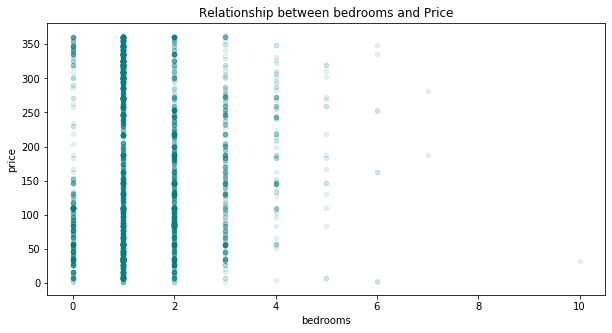

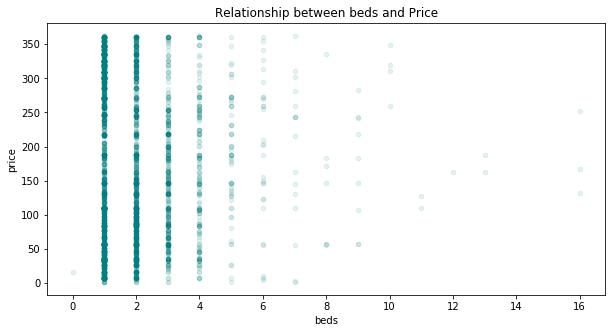

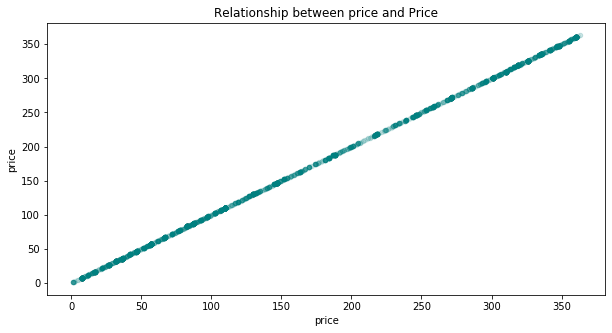

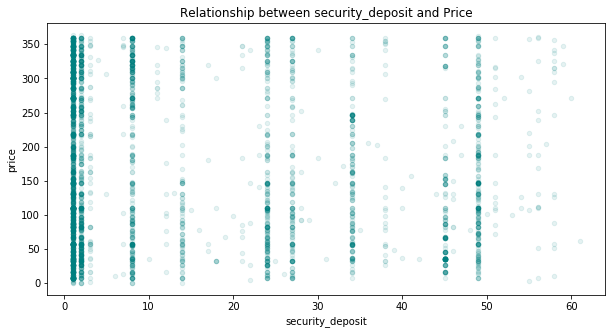

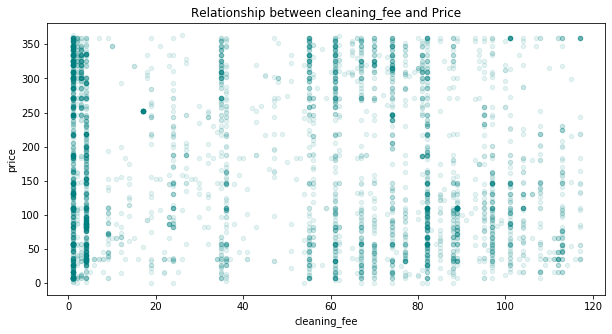

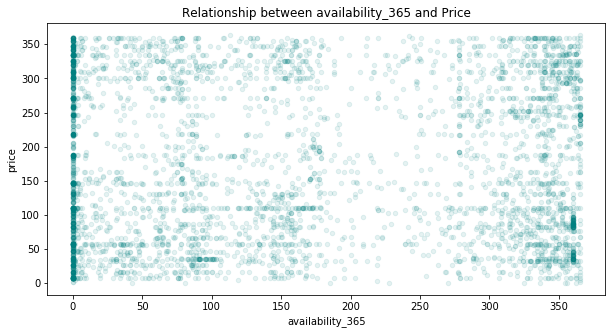

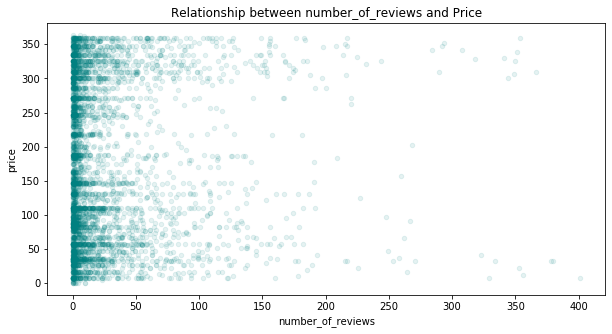

12


In [47]:
hi= 0
for feature in predictors:
    feat_plot = listings_train.plot.scatter(x="{}".format(feature),y='price',c='Teal',title="Relationship between {} and Price".format(feature),alpha=0.1)
    feat_plot.set_xlabel("{}".format(feature))
    hi +=1
    plt.show()
print(hi)
    

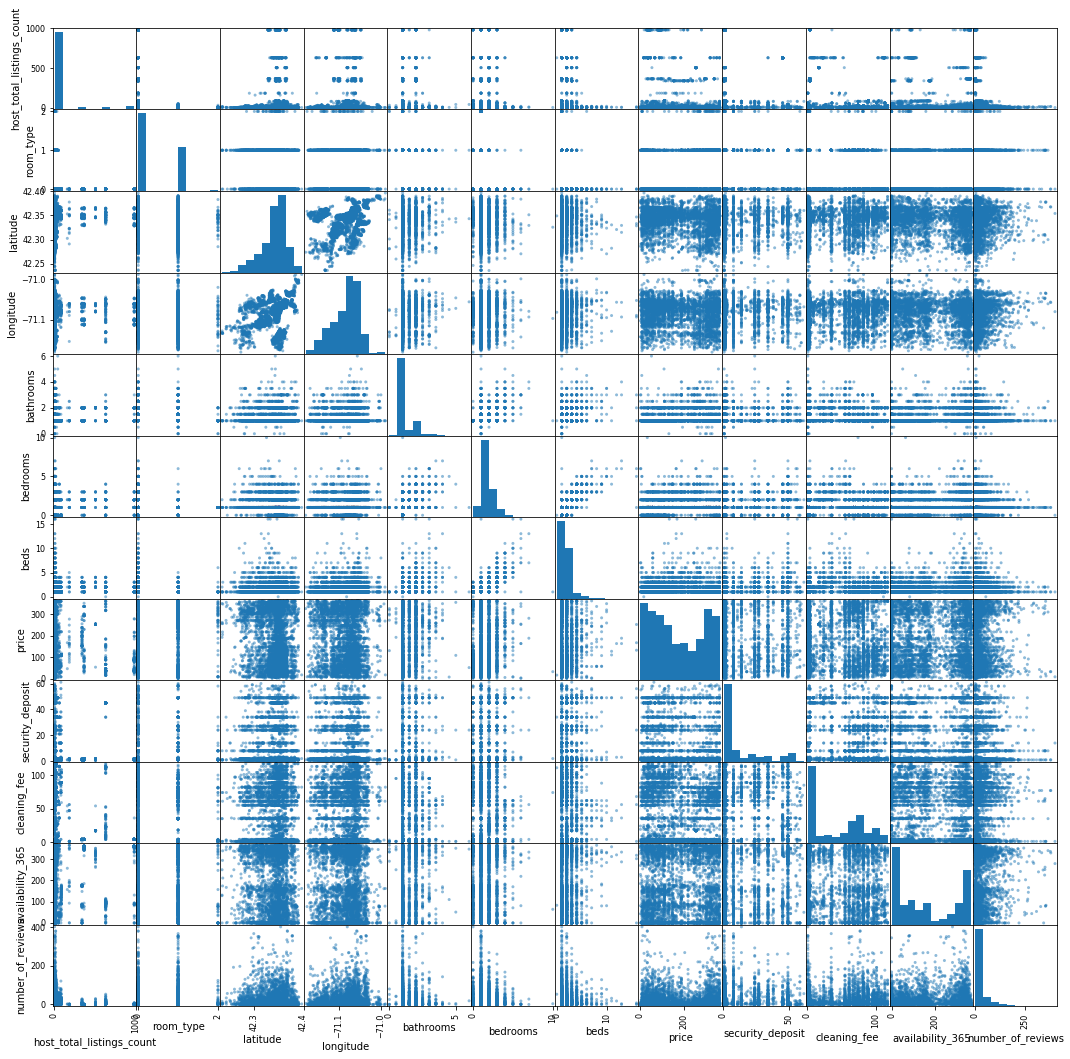

In [48]:
pd.plotting.scatter_matrix(listings_train,figsize=(18,18));


Based on the scatterplots of each predictor when price is the response variable (8th row from the top in the scatter matrix above), the following predictor variables do not seem to have linear relationships with price: host_total_listings_count, latitude, longitude, bathrooms, bedrooms, beds, security_deposit, cleaning_fee, availability_365, and number_of_reviews. There is no clear linear relation between these predictors and price. The number_of_reviews and availability_365 specifically have bimodel distributions in the scatterplot against price. 

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [49]:
# listings_train.columns

listings_train.room_type

0       1
1       0
2       0
3       0
4       0
       ..
4365    0
4366    0
4367    1
4368    2
4369    0
Name: room_type, Length: 4370, dtype: int64

In [50]:
# linear regression

fit2_lm = sm.ols(formula="price ~ host_total_listings_count + room_type + latitude + longitude + bathrooms + bedrooms + beds + security_deposit + cleaning_fee + availability_365 + number_of_reviews",data=listings_train).fit()

poly_predictions = fit2_lm.get_prediction(listings_train.drop(columns=['price'],inplace=False)).summary_frame()


print('train r2:', r2_score(listings_train['price'], fit2_lm.predict(listings_train.drop(columns=['price'],inplace=False))))
print('test r2:', r2_score(listings_test['price'], fit2_lm.predict(listings_test.drop(columns=['price'],inplace=False))))



train r2: 0.24158791171094407
test r2: 0.18134222802364264


In [51]:
# polynomial basis functions of degree 3 for quantitative features

fit2_lm = sm.ols(formula="price ~ host_total_listings_count + np.power(host_total_listings_count,2) + np.power(host_total_listings_count,3) + room_type + latitude + np.power(latitude,2) + np.power(latitude,3) + longitude + np.power(longitude,2) + np.power(longitude,3) + bathrooms + np.power(bathrooms,2) + np.power(bathrooms,3) + bedrooms + np.power(bedrooms,2) + np.power(bedrooms,3) + beds + np.power(beds,2) + np.power(beds,3) + security_deposit + np.power(security_deposit,2) + np.power(security_deposit,3) + cleaning_fee + np.power(cleaning_fee,2) + np.power(cleaning_fee,3) + availability_365 + np.power(availability_365,2) + np.power(availability_365,3) + number_of_reviews + np.power(number_of_reviews,2) + np.power(number_of_reviews,3)",data=listings_train).fit()

poly_predictions = fit2_lm.get_prediction(listings_train.drop(columns=['price'],inplace=False)).summary_frame()


print('train r2:', r2_score(listings_train['price'], fit2_lm.predict(listings_train.drop(columns=['price'],inplace=False))))
print('test r2:', r2_score(listings_test['price'], fit2_lm.predict(listings_test.drop(columns=['price'],inplace=False))))


train r2: 0.2632384800715253
test r2: 0.2346209801122071


The training and testing $R^2$ values were 0.25 and 0.18, respectively, for the linear regression. The training and testing $R^2$ values were 0.27 and 0.24, respectively, for the regression with polynomial basis functions of degree 3 for each predictor for quantitative predictors.

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


The advantage of fitting an additive regression model is that it can capture more complex relations between predictors and response variables. Additive regression models can add nonlinear relations so if many predictors are nonlinear, the using an additive regression model which can add together multiple splines can capture more of the nonlinearity. We do see some predictors having nonlinear contributions to the response so an additive regression model may be helpful.


In [52]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

In [53]:
# create training preidctors and encode the room type variable as integers

X_train=listings_train.drop(columns=['price'],inplace=False)
le_train=LabelEncoder().fit(X_train.room_type)
le_train.transform(X_train.room_type)
print('label encoding mappings:', le_train.classes_)
X_train['room_type_encoded'] = le_train.transform(X_train.room_type)
X_train=X_train.drop(columns=['room_type'],inplace=False)

# create testing preidctors and encode the room type variable as integers

X_test=listings_test.drop(columns=['price'],inplace=False)
le_test=LabelEncoder().fit(X_test.room_type)
le_test.transform(X_test.room_type)
X_test['room_type_encoded'] = le_test.transform(X_test.room_type)
X_test=X_test.drop(columns=['room_type'],inplace=False)

# train GAM with room type as a factor since encoded categorical variable
gam = LinearGAM(s(0) + s(1) + s(2) + s(3)+ s(4)+ s(5)+ s(6)+ s(7)+ s(8)+ s(9) + f(10)).fit(X_train,listings_train['price'])
check_smoothings=np.logspace(-3,3,11)
gam.gridsearch(X_train, listings_train['price'],lam=check_smoothings)

print('test r2:', r2_score(listings_test['price'], gam.predict(X_test)))


label encoding mappings: [0 1 2]


100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


test r2: 0.24136711284915857


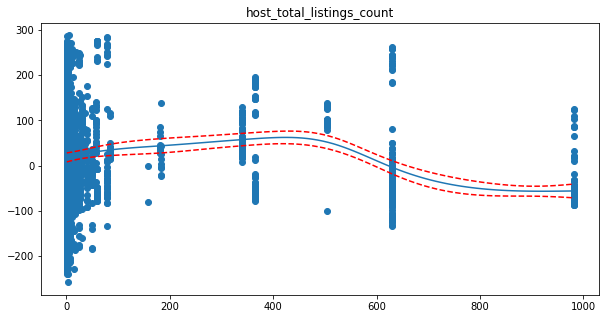

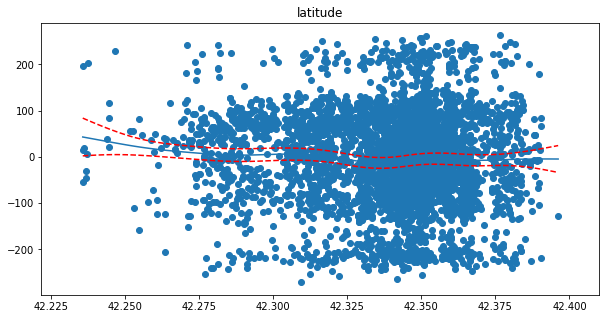

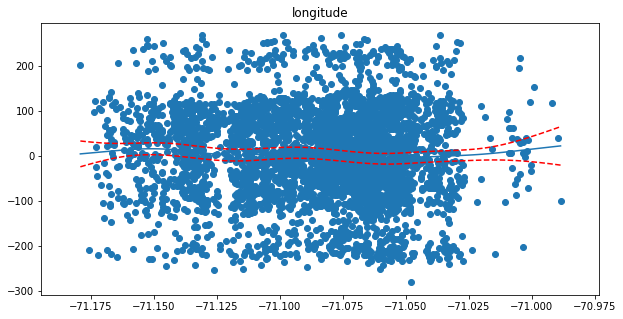

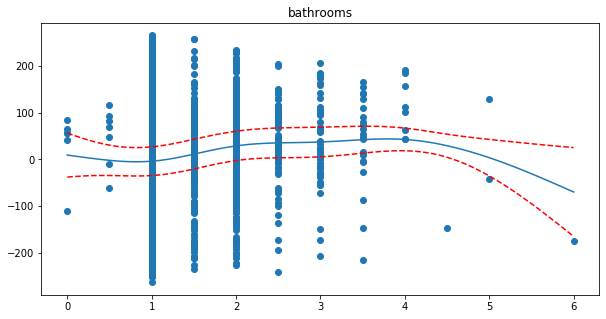

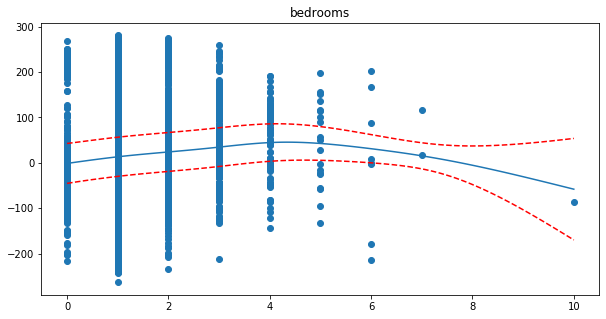

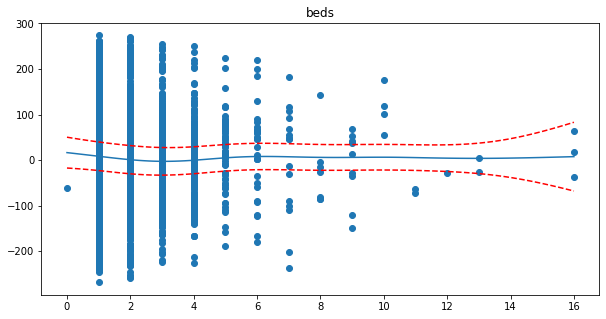

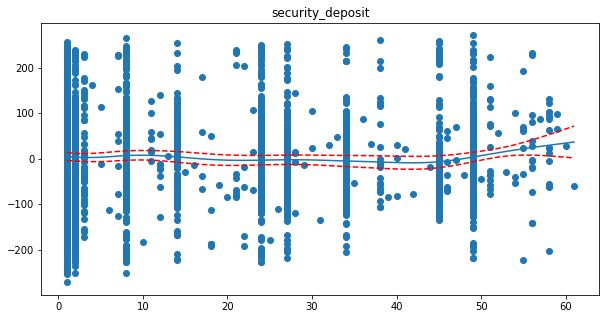

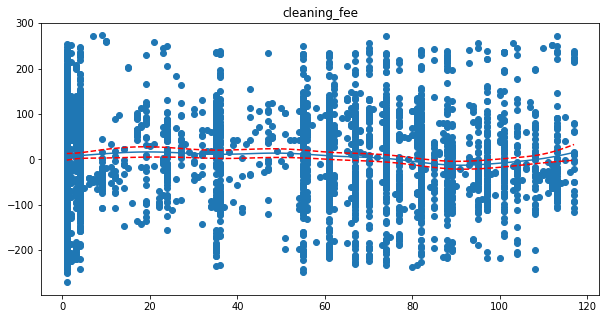

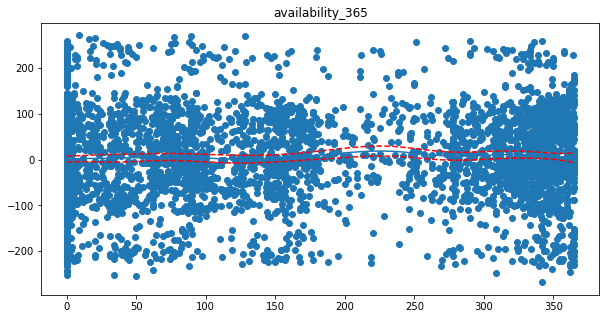

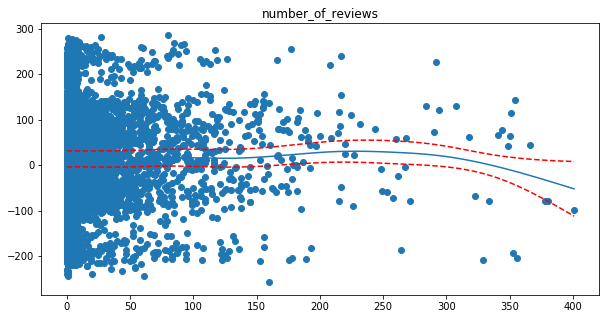

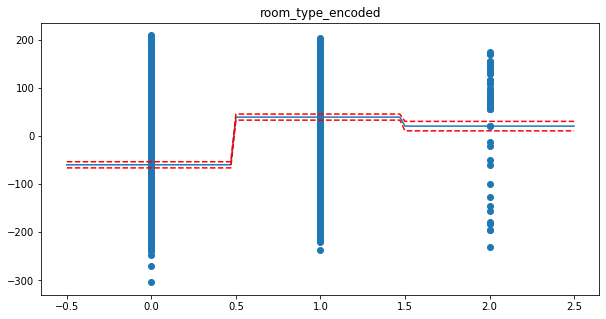

In [54]:
# code from lab 2
# show partial dependence plots to see how each predictor relates to outcome
# GAMs provide plots of the effect of increasing each variable (conditional on / adjusted for the other variables)

res = gam.deviance_residuals(X_train, listings_train['price'])
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = gam.partial_dependence(term=i, X=X_train, width=0.95)
    plt.figure()
    plt.scatter(X_train.iloc[:,term.feature], pdep2 + res)
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(X_train.columns.values[term.feature])
    plt.show()

By examining the smooth of each predictor in the partial dependence plots, we can see that a host having a lot of listings can indicate a smaller price and hosts with about 500 listings may be more expensive (since price is high fr these hosts with 500 listings and lower once listings count increases). We can see that latitude does not have much of an effect on price since increases latitude does not change price much in the partial dependence plot. Although higher longitudes appear to have higher prices, the relation is only apparent where there is not much data so we have poor confidence in this effect. Many bathrooms may indicate a smaller price but again there is limited data for rentals with that many bathrooms so the effect is not clear. Listings with about 4 bedrooms tend to increase price the most. The number of beds, the size of security deposit, the size of the cleaning fee, the availability, and the number of reviews all do not seem to have much of an effect on price since the partial dependence plots do not have a nonzero slope in many places. The private room type has the greatest effect on increasing price while the entire homes and apartments category increases price the least (negative value at y axis in the partial dependence plot).

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

The most important variables in driving prices are room type ('Entire home/apt', 'Private room', or 'Shared room') and  the host's total listings. This is because the partial dependence plots show the greatest change in the y variable (price) as the predictor changes. The traveler visiting Boston should choose a host offering many listings (1000) as opposed to 500 listings as the high number of listings may indicate a cheaper price. Moreover, the traveler should select an entire home or apartment to have a cheaper price comapred to listings that are called private rooms or shared rooms. We chose these two variables as improtant because they have partial dependence plots with the most obvious nonzero slopes as the predictor changes in the setting of sufficient data points. We do not consider instances of nonzero slope for the partial dependence plots to be important if they are established based on very limited data (such as at the very edge of the domain of the predictor). We use insights from part 1 to bolster support for these predictors as being important because the 

In [55]:
#write up on problem, what you saw on data for 2a part what did models do, interpret the models how we can improve the results, suggestions for the traveler visiting boston